**UIT-ViSD4SA Baseline Model Implementation**
* Task: Aspect-Based Sentiment Analysis (ABSA) for Vietnamese Smartphone Reviews.
* Architecture: XLM-Roberta (Context) + Char-CNN + Syllable Embedding -> BiLSTM -> CRF.
* Based on idea of: https://aclanthology.org/2021.paclic-1.34/
* Data: https://github.com/kimkim00/UIT-ViSD4SA
* Implement and Optimize by: nqhuy.aie@gmail.com

# Library & Environment setup

In [4]:
!pip install protobuf==3.20.* --upgrade -q
!pip install pytorch-crf vncorenlp py_vncorenlp seaborn -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 9.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
pydrive2 1.21.3 requires cryptography<44, bu

In [5]:
import os
import json
import random
import copy
import warnings
from typing import List, Tuple, Dict, Set, Any, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from collections import Counter

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.amp import autocast, GradScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from transformers import XLMRobertaTokenizerFast, XLMRobertaModel
from torchcrf import CRF
import py_vncorenlp
from vncorenlp import VnCoreNLP

# Turn off this line because it has effect 
# due to this blog: https://discuss.pytorch.org/t/about-torch-cuda-empty-cache/34232
# torch.cuda.empty_cache()

2025-12-19 18:04:31.349651: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766167471.530771      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766167471.588585      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Configuration

In [6]:
class Config:
    """Hyperparameters and configuration settings."""
    SEED = 42
    VNCORE_DIR = "./vncorenlp"
    DATA_DIR = "/kaggle/input/uit-visd4sa-expanded"
    WORK_DIR = "./"
    
    # Model Architecture
    CONTEXT_MODEL = "xlm-roberta-base" 
    CONTEXT_DIM = 768
    SYLLABLE_EMB_DIM = 100
    CHAR_EMB_DIM = 100
    CHAR_HIDDEN_DIM = 50
    LSTM_HIDDEN_DIM = 256
    LSTM_DROPOUT = 0.5

    USE_CHAR_EMB = False
    
    # Training
    KFOLD_SPLIT = 5 
    BATCH_SIZE = 32
    EPOCHS = 30
    LR = 1e-3          # Lr for the LSTM-CRF layer
    ENCODER_LR = 1e-5  # Lr for the Transformer Encoder (XLM-Roberta)
    PATIENCE = 5
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    DEVICE_NAME = torch.cuda.get_device_name()

    # Labels Definition
    ASPECTS = [
        "SCREEN","CAMERA",
        "FEATURES","BATTERY",
        "PERFORMANCE","STORAGE",
        "DESIGN","PRICE",
        "GENERAL","SER&ACC"
    ]
    POLARITIES = ["NEGATIVE","NEUTRAL","POSITIVE"]

# Ultilites

In [7]:
def seed_everything(seed: int = 42):
    """Sets the random seed for reproducibility."""
    random.seed(seed)
    os.environ["TOKENIZERS_PARALLELISM"] = "false"
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
    print(f"[INFO] Random seed set to {seed}")

def read_jsonl(path: str) -> List[Dict]:
    """Reads a JSONL file and returns a list of dictionaries."""
    with open(path, 'r', encoding='utf8') as f:
        return [json.loads(line) for line in f]

# Preprocessing function

In [8]:
class Preprocessor:
    """Handles Tokenization, Alignments, and Vocabulary building."""
    
    def __init__(self, vncore_dir: str):
        self.vncore_dir = vncore_dir
        self.tokenizer = XLMRobertaTokenizerFast.from_pretrained(Config.CONTEXT_MODEL)
        self._setup_vncorenlp()
        self.label_map, self.id2label = self._build_label_map()
        self.syl_vocab = {"<PAD>": 0, "<UNK>": 1}
        self.char_vocab = {"<PAD>": 0, "<UNK>": 1}

    def _setup_vncorenlp(self):
        """Initializes VnCoreNLP for Vietnamese word segmentation."""
        if not os.path.exists(self.vncore_dir):
            os.makedirs(self.vncore_dir, exist_ok=True)
            py_vncorenlp.download_model(save_dir=self.vncore_dir)
        
        self.vncore = VnCoreNLP(
            address=os.path.join(self.vncore_dir, "VnCoreNLP-1.2.jar"),
            annotators="wseg,pos,ner,parse",
            quiet=True
        )

    def _build_label_map(self) -> Tuple[Dict, Dict]:
        """Creates mapping for Aspect#Polarity IOB tags."""
        labels = ["O"]
        for a in Config.ASPECTS:
            for p in Config.POLARITIES:
                labels.extend([f"B-{a}#{p}", f"I-{a}#{p}"])
        label_map = {l: i for i, l in enumerate(labels)}
        id2label = {v: k for k, v in label_map.items()}
        return label_map, id2label

    def tokenize_and_align(self, text: str) -> Tuple[List[str], List[int]]:
        """
        Tokenizes text using VnCoreNLP and aligns tokens to original character indices.
        """
        try:
            annotated = self.vncore.annotate(text)
        except Exception:
            return [], []

        tokens = []
        starts = []
        current_idx = 0
        
        for sent in annotated['sentences']:
            for token in sent:
                form = token['form'].replace('_', ' ')
                start = text.find(form, current_idx)
                if start != -1:
                    tokens.append(token['form'])
                    starts.append(start)
                    current_idx = start + len(form)
        return tokens, starts

    def spans_to_iob(self, tokens: List[str], starts: List[int], spans: List) -> List[str]:
        """Converts (start, end, label) spans to IOB tag sequence."""
        tags = ["O"] * len(tokens)
        for s, e, label in spans:
            # Find token indices covered by this span
            indices = [i for i, st in enumerate(starts)
                       if not (st + len(tokens[i].replace('_',' ')) <= s or st >= e)]
            if not indices: continue
            
            tags[indices[0]] = f"B-{label}"
            for k in indices[1:]:
                tags[k] = f"I-{label}"
        return tags

    def build_vocabs(self, dataset: List[Dict]):
        """Builds syllable and character vocabularies from the dataset."""
        for item in dataset:
            for token in item['tokens']:
                if token not in self.syl_vocab:
                    self.syl_vocab[token] = len(self.syl_vocab)
                for char in token:
                    if char not in self.char_vocab:
                        self.char_vocab[char] = len(self.char_vocab)
        print(f"[INFO] Vocab Built | Syllables: {len(self.syl_vocab)}, Chars: {len(self.char_vocab)}")

    def process_data(self, data: List[Dict], desc: str = "Processing") -> List[Dict]:
        """
        Main processing pipeline: VnCoreNLP Tokenization -> Alignment -> XLM-R Tokenization.
        """
        processed_samples = []
        for item in tqdm(data, desc=desc):
            tokens, starts = self.tokenize_and_align(item['text'])
            if not tokens: continue

            tags = self.spans_to_iob(tokens, starts, item['labels'])

            # Tokenize using XLM-Roberta
            encoding = self.tokenizer(
                tokens,
                is_split_into_words=True,
                padding=False,
                truncation=True,
                max_length=256,
                add_special_tokens=False
            )

            processed_samples.append({
                "input_ids": encoding['input_ids'],
                "word_ids": encoding.word_ids(),
                "tokens": tokens,
                "starts": starts,
                "tags": tags,
                "labels": item['labels'],
                "text": item['text']
            })
        return processed_samples

    @staticmethod
    def iob_to_spans(tokens: List[str], starts: List[int], tags: List[str]) -> List[Tuple]:
        """Converts IOB tags back to (start, end, label) spans."""
        spans = []
        i = 0
        while i < len(tags):
            tag = tags[i]
            if tag.startswith("B-"):
                label = tag[2:]
                start = starts[i]
                j = i + 1
                while j < len(tags) and tags[j] == f"I-{label}":
                    j += 1
                
                last_token_len = len(tokens[j-1].replace('_', ' '))
                end = starts[j-1] + last_token_len
                spans.append((start, end, label))
                i = j
            else:
                i += 1
        return spans

# Dataset

In [9]:
class ABSADataset(Dataset):
    def __init__(self, data: List[Dict]):
        self.data = data
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]

class CollateFn:
    """Custom collate function to handle variable length padding and subword mapping."""
    
    def __init__(self, syl_vocab, char_vocab, label_map, device):
        self.syl_vocab = syl_vocab
        self.char_vocab = char_vocab
        self.label_map = label_map
        self.device = device
        self.max_word_char_len = 20

    def __call__(self, batch):
        batch_size = len(batch)
        max_seq_len = max([len(x['tokens']) for x in batch])
        max_subword_len = max([len(x['input_ids']) for x in batch])

        # Initialize Tensors
        input_ids_tensor = torch.zeros(batch_size, max_subword_len, dtype=torch.long, device=self.device)
        attention_mask = torch.zeros(batch_size, max_subword_len, dtype=torch.long, device=self.device)
        
        # Mapping matrix: (Batch, Word_Len, Subword_Len)
        # Used to aggregate subword embeddings back to word level
        subword_to_word_map = torch.zeros(batch_size, max_seq_len, max_subword_len, device=self.device)

        syl_tensor = torch.zeros(batch_size, max_seq_len, dtype=torch.long, device=self.device)
        char_tensor = torch.zeros(batch_size, max_seq_len, self.max_word_char_len, dtype=torch.long, device=self.device)
        tag_tensor = torch.zeros(batch_size, max_seq_len, dtype=torch.long, device=self.device)
        mask = torch.zeros(batch_size, max_seq_len, dtype=torch.bool, device=self.device)

        # Metadata containers
        original_tokens = []
        original_starts = []
        original_labels = []
        original_texts = []

        for i, item in enumerate(batch):
            # 1. Fill XLM-R Inputs
            input_ids = item['input_ids']
            sub_len = len(input_ids)
            input_ids_tensor[i, :sub_len] = torch.tensor(input_ids)
            attention_mask[i, :sub_len] = 1

            # 2. Build Subword -> Word Mapping (Mean Pooling)
            word_ids = item['word_ids']
            for sub_idx, w_idx in enumerate(word_ids):
                if w_idx is not None and w_idx < max_seq_len:
                    subword_to_word_map[i, w_idx, sub_idx] = 1.0
            
            # Normalize mapping for mean pooling
            subword_counts = subword_to_word_map[i].sum(dim=1, keepdim=True)
            subword_counts[subword_counts == 0] = 1  # Prevent div by zero
            subword_to_word_map[i] = subword_to_word_map[i] / subword_counts

            # 3. Fill Syllable, Char, Tag inputs
            cur_len = len(item['tokens'])
            mask[i, :cur_len] = True

            syl_ids = [self.syl_vocab.get(t, 1) for t in item['tokens']]
            syl_tensor[i, :cur_len] = torch.tensor(syl_ids)

            for j, token in enumerate(item['tokens']):
                c_ids = [self.char_vocab.get(c, 1) for c in token][:self.max_word_char_len]
                char_tensor[i, j, :len(c_ids)] = torch.tensor(c_ids)

            t_ids = [self.label_map.get(t, 0) for t in item['tags']]
            tag_tensor[i, :cur_len] = torch.tensor(t_ids)

            original_tokens.append(item['tokens'])
            original_starts.append(item['starts'])
            original_labels.append(item['labels'])
            original_texts.append(item['text'])

        return (input_ids_tensor, attention_mask, subword_to_word_map, 
                syl_tensor, char_tensor, tag_tensor, mask, 
                original_tokens, original_starts, original_labels, original_texts)

# Model Architecture

In [10]:
class CharCNN_LSTM(nn.Module):
    """Character-level embedding module using BiLSTM."""
    
    def __init__(self, vocab_size: int, emb_dim: int, hidden_dim: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.dropout = nn.Dropout(0.3)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, batch_first=True, bidirectional=True)

    def forward(self, x):
        # Input x: (Batch, Seq_Len, Word_Len)
        B, S, W = x.shape
        x_flat = x.view(-1, W)
        emb = self.dropout(self.embedding(x_flat))
        
        # LSTM output
        _, (h_n, _) = self.lstm(emb)
        # Concatenate forward and backward hidden states
        # Shape: (Batch*Seq_Len, 2*Hidden)
        out = torch.cat((h_n[-2], h_n[-1]), dim=1) 
        return out.view(B, S, -1)

class BiLSTM_CRF(nn.Module):
    """
    Hybrid Model: XLM-R + Syllable Emb + Char Emb -> BiLSTM -> CRF
    """
    def __init__(self, num_labels: int, syl_vocab_size: int, char_vocab_size: int):
        super().__init__()

        # 1. Transformer Backbone
        self.xlm = XLMRobertaModel.from_pretrained(Config.CONTEXT_MODEL)
        self._freeze_xlm_layers()

        # 2. Additional Embeddings
        self.syl_emb = nn.Embedding(syl_vocab_size, Config.SYLLABLE_EMB_DIM, padding_idx=0)
        if Config.USE_CHAR_EMB:
            self.char_enc = CharCNN_LSTM(char_vocab_size, Config.CHAR_EMB_DIM, Config.CHAR_HIDDEN_DIM)
            char_out_dim = Config.CHAR_HIDDEN_DIM * 2
            print(f"CHAR OUT DIM: {char_out_dim}")
        else:
            self.char_enc = None
            char_out_dim = 0

        # 3. Fusion Projection
        fusion_dim = Config.CONTEXT_DIM + Config.SYLLABLE_EMB_DIM + char_out_dim
        self.fusion_proj = nn.Linear(fusion_dim, fusion_dim)

        # 4. Decoder (BiLSTM + CRF)
        self.bilstm = nn.LSTM(fusion_dim, Config.LSTM_HIDDEN_DIM // 2,
                              batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(Config.LSTM_DROPOUT)
        self.hidden2tag = nn.Linear(Config.LSTM_HIDDEN_DIM, num_labels)
        self.crf = CRF(num_labels, batch_first=True)

    def _freeze_xlm_layers(self):
        """Freeze earlier layers of XLM-R, unfreeze last 4 layers."""
        for param in self.xlm.parameters():
            param.requires_grad = False
        
        # Unfreeze last 4 layers
        for param in self.xlm.encoder.layer[-4:].parameters():
            param.requires_grad = True
        
        if hasattr(self.xlm, 'pooler') and self.xlm.pooler is not None:
             for param in self.xlm.pooler.parameters():
                param.requires_grad = True

    def forward(self, input_ids, attention_mask, subword_map, syl_ids, char_ids, mask=None, tags=None):
        # 1. Contextual Embeddings (XLM-R)
        xlm_out = self.xlm(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        
        # Aggregate Subwords -> Words
        word_embs = torch.bmm(subword_map, xlm_out) # (Batch, Word_Len, Dim)

        # 2. Feature Embeddings
        s_emb = self.syl_emb(syl_ids)
        features_list = [word_embs, s_emb]
        
        if Config.USE_CHAR_EMB and self.char_enc is not None:
            c_emb = self.char_enc(char_ids)
            features_list.append(c_emb)

        # 3. Fusion
        fused = torch.cat(features_list, dim=-1)
        fused = self.dropout(torch.relu(self.fusion_proj(fused)))

        # 4. Sequential Modeling
        lstm_out, _ = self.bilstm(fused)
        lstm_out = self.dropout(lstm_out)
        emissions = self.hidden2tag(lstm_out)

        # 5. CRF Output
        if tags is not None:
            # Return Negative Log Likelihood
            return -self.crf(emissions, tags, mask=mask, reduction='mean')
        else:
            # Return Best Path
            return self.crf.decode(emissions, mask=mask)

# Evaluation Metrics

In [11]:
def compute_metrics(preds: List[Set], golds: List[Set]) -> Tuple[float, float, float]:
    """
    Computes strict match Precision, Recall, and F1.
    Args:
        preds: List of sets, where each set contains tuples (start, end, label)
        golds: List of sets, where each set contains tuples (start, end, label)
    """
    tp = sum(len(p & g) for p, g in zip(preds, golds))
    total_p = sum(len(p) for p in preds)
    total_g = sum(len(g) for g in golds)

    prec = tp / total_p if total_p > 0 else 0.0
    rec = tp / total_g if total_g > 0 else 0.0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0
    
    return prec, rec, f1

def compute_span_metrics(preds: List[Set], golds: List[Set]) -> Tuple[float, float, float]:
    """
    Computes Precision, Recall, and F1 for SPAN DETECTION only (ignoring labels).
    """
    span_preds = [set((s, e) for s, e, _ in p) for p in preds]
    span_golds = [set((s, e) for s, e, _ in g) for g in golds]

    return compute_metrics(span_preds, span_golds)

def print_detailed_report(preds: List[Set], golds: List[Set]):
    print(f"\n{'='*15} DETAILED REPORT BY ASPECT {'='*15}")
    print(f"{'ASPECT':<15} {'PRECISION':<12} {'RECALL':<10} {'F1-SCORE':<10}")
    print("-" * 50)
    
    results = {}

    for aspect in Config.ASPECTS:
        aspect_preds = []
        aspect_golds = []
        
        for p_set, g_set in zip(preds, golds):
            p_sub = set()
            for (s, e, label) in p_set:
                if label.split('#')[0] == aspect:
                    p_sub.add((s, e, label))
            aspect_preds.append(p_sub)
            
            g_sub = set()
            for (s, e, label) in g_set:
                if label.split('#')[0] == aspect:
                    g_sub.add((s, e, label))
            aspect_golds.append(g_sub)
            
        prec, rec, f1 = compute_metrics(aspect_preds, aspect_golds)
        
        results[aspect] = f1
        print(f"{aspect:<15} {prec*100:<12.2f} {rec*100:<10.2f} {f1*100:<10.2f}")
        
    print("-" * 50)
    
    macro_f1 = sum(results.values()) / len(results) if results else 0.0
    print(f"{'MACRO AVG':<15} {'-':<12} {'-':<10} {macro_f1*100:<10.2f}")
    return macro_f1

# Training

In [9]:
def train_epoch(model, loader, optimizer, scaler):
    model.train()
    epoch_loss = 0
    for batch in tqdm(loader, desc="Training", leave=False):
        optimizer.zero_grad()
        
        # Unpack batch (first 7 items are inputs)
        inputs = batch[:7]
        input_ids, att_mask, sw_map, syl, char, tags, mask = inputs
        
        with autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
            loss = model(input_ids, att_mask, sw_map, syl, char, mask=mask, tags=tags)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
    
    return epoch_loss / len(loader)

def evaluate(model, loader, id2label, preprocessor, verbose=False):
    model.eval()
    all_preds = []
    all_golds = []
    total_loss = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating", leave=False):
            input_ids, att_mask, sw_map, syl, char, tags, mask, tokens, starts, labels, _ = batch

            # Calculate Loss
            with autocast(device_type="cuda" if torch.cuda.is_available() else "cpu"):
                loss = model(input_ids, att_mask, sw_map, syl, char, mask=mask, tags=tags)
            total_loss += loss.item()

            # Decode Paths
            pred_tags_ids = model(input_ids, att_mask, sw_map, syl, char, mask=mask)

            for i, tag_ids in enumerate(pred_tags_ids):
                current_tags = [id2label[t] for t in tag_ids]
                pred_spans = set(preprocessor.iob_to_spans(tokens[i], starts[i], current_tags))
                gold_spans = set([tuple(l) for l in labels[i]])

                all_preds.append(pred_spans)
                all_golds.append(gold_spans)

    avg_loss = total_loss / len(loader)
    span_p, span_r, span_f1 = compute_span_metrics(all_preds, all_golds)
    p, r, f1 = compute_metrics(all_preds, all_golds)

    if verbose:
        print_detailed_report(all_preds, all_golds)

    return span_p, span_r, span_f1, p, r, f1, avg_loss

def get_sample_weights(dataset):
    """Calculates weights for WeightedRandomSampler to handle class imbalance."""
    weights = []
    minority_classes = ["STORAGE", "PRICE", "SER&ACC"]
    
    for item in dataset:
        weight = 1.0
        has_minority = False
        for _, _, label in item['labels']:
            if label.split('#')[0] in minority_classes:
                has_minority = True
                break
        if has_minority:
            weight = 5.0
        weights.append(weight)
    return torch.DoubleTensor(weights)

# EDA

In [18]:
def plot_aspect_distribution(data, title="Aspect and Polarity Distribution"):
    all_aspects = []
    all_polarities = []
    aspect_polarity_pairs = []

    for item in data:
        for label_info in item['labels']:
            # Label format: [start, end, "ASPECT#POLARITY"]
            label_str = label_info[2]
            try:
                aspect, polarity = label_str.split('#')
                aspect_polarity_pairs.append({'Aspect': aspect, 'Sentiment': polarity})
            except ValueError:
                continue

    df = pd.DataFrame(aspect_polarity_pairs)

    summary_df = df.groupby(['Aspect', 'Sentiment']).size().unstack(fill_value=0)
    
    desired_order = ['NEGATIVE', 'NEUTRAL', 'POSITIVE']
    for col in desired_order:
        if col not in summary_df.columns:
            summary_df[col] = 0
    summary_df = summary_df[desired_order]
    summary_df['TOTAL'] = summary_df.sum(axis=1)
    summary_df = summary_df.sort_values(by='TOTAL', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.set_theme(style="whitegrid")

    plot_df = summary_df[['NEGATIVE', 'NEUTRAL', 'POSITIVE']]
    
    plot_df.plot(kind='bar', stacked=True, ax=plt.gca(), 
                  color=['#e74c3c', '#95a5a6', '#2ecc71'])
    
    plt.title(title, fontsize=15)
    plt.ylabel('Samples', fontsize=12)
    plt.xlabel('Aspect', fontsize=12)
    plt.legend(title='Sentiment', title_fontsize='12')
    plt.xticks(rotation=45)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    print(f"Total samples: {len(df)}")

    return summary_df

def plot_fold_history(history, fold_idx):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-o', label='Train Loss')
    plt.plot(epochs, history['val_loss'], 'r-o', label='Val Loss')
    plt.title(f'FOLD {fold_idx} - LOSS')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['val_f1'], 'g-s', label='Val F1 (Full)')
    plt.plot(epochs, history['val_span_f1'], 'm-^', label='Val F1 (Span)')
    plt.title(f'FOLD {fold_idx} - F1 SCORE')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()
    plt.close()

def get_predictions_arrays(model, loader):
    model.eval()
    all_preds = []
    all_golds = []
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Getting Predictions"):
            input_ids, att_mask, sw_map, syl, char, tags, mask, _, _, _, _ = batch
            
            pred_tags_ids = model(input_ids, att_mask, sw_map, syl, char, mask=mask)
            
            for i in range(len(tags)):
                length = mask[i].sum().item()
                gold_slice = tags[i][:length].cpu().numpy().tolist()
                pred_slice = pred_tags_ids[i]
                
                all_golds.extend(gold_slice)
                all_preds.extend(pred_slice)
                
    return all_golds, all_preds

def plot_confusion_matrix_heatmap(golds, preds, id2label, mode='sentiment', fig_size=(6, 6)):

    mapped_golds = []
    mapped_preds = []
    
    for g, p in zip(golds, preds):
        l_g = id2label[g]
        l_p = id2label[p]
        
        if l_g == 'O' and l_p == 'O': 
            continue 

        if mode == 'sentiment':
            token_g = l_g.split('#')[-1] if '#' in l_g else 'O'
            token_p = l_p.split('#')[-1] if '#' in l_p else 'O'
        
        elif mode == 'aspect':
            if '#' in l_g:
                token_g = l_g.split('#')[0].split('-')[1] # B-SCREEN -> SCREEN
            else:
                token_g = 'O'
                
            if '#' in l_p:
                token_p = l_p.split('#')[0].split('-')[1]
            else:
                token_p = 'O'
        else:
            token_g, token_p = l_g, l_p

        mapped_golds.append(token_g)
        mapped_preds.append(token_p)

    labels = sorted(list(set(mapped_golds + mapped_preds)))
    if 'O' in labels:
        labels.remove('O')
        labels.append('O')

    cm = confusion_matrix(mapped_golds, mapped_preds, labels=labels)
    
    plt.figure(figsize=fig_size)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels, yticklabels=labels)
    plt.title(f"Confusion Matrix - {mode.upper()} Level")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

def plot_sentence_length_distribution(data, title="Sentence Length Distribution"):
    lengths = [len(item['text'].split()) for item in data]
    
    plt.figure(figsize=(10, 6))
    sns.set_theme(style="whitegrid")
    
    sns.histplot(lengths, kde=True, bins=50, color='#3498db', edgecolor='white')
    
    plt.title(title, fontsize=15)
    plt.xlabel('Sentence Length (words)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    
    mean_len = np.mean(lengths)
    max_len = np.max(lengths)
    p95 = np.percentile(lengths, 95)
    
    plt.axvline(mean_len, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_len:.1f}')
    plt.axvline(p95, color='green', linestyle='--', linewidth=2, label=f'95th %tile: {p95:.1f}')
    
    plt.legend()
    plt.tight_layout()
    plt.show()

    print(f"[{title}] Statistics:")
    print(f"  - Mean length: {mean_len:.2f}")
    print(f"  - Max length:  {max_len}")
    print(f"  - Min length:  {np.min(lengths)}")
    print(f"  - 95th %tile:  {p95:.2f}")

# Main pipeline

[INFO] Random seed set to 42
[INFO] Running on device: cuda
[INFO] Loading and preprocessing data...


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


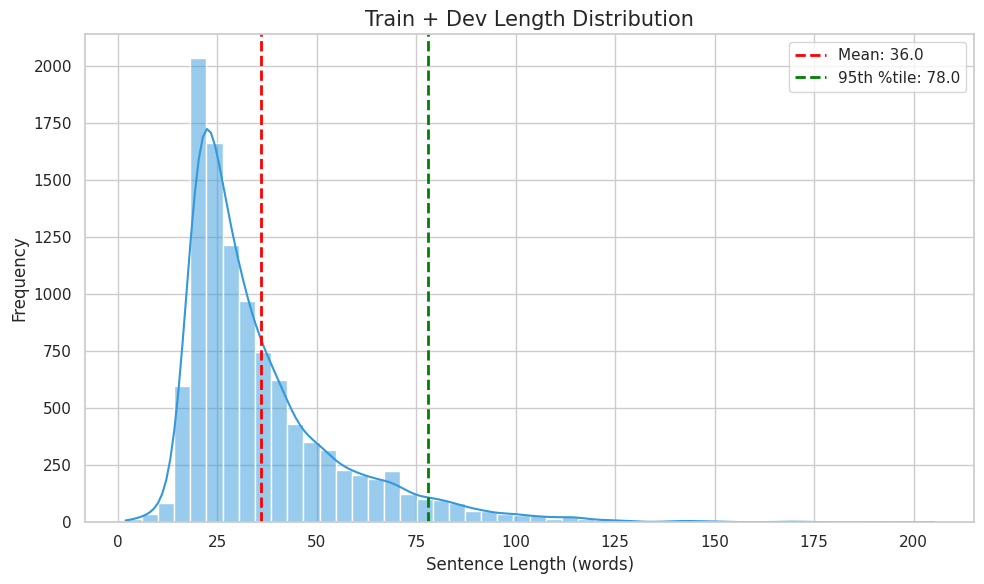

[Train + Dev Length Distribution] Statistics:
  - Mean length: 35.99
  - Max length:  205
  - Min length:  2
  - 95th %tile:  78.00


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


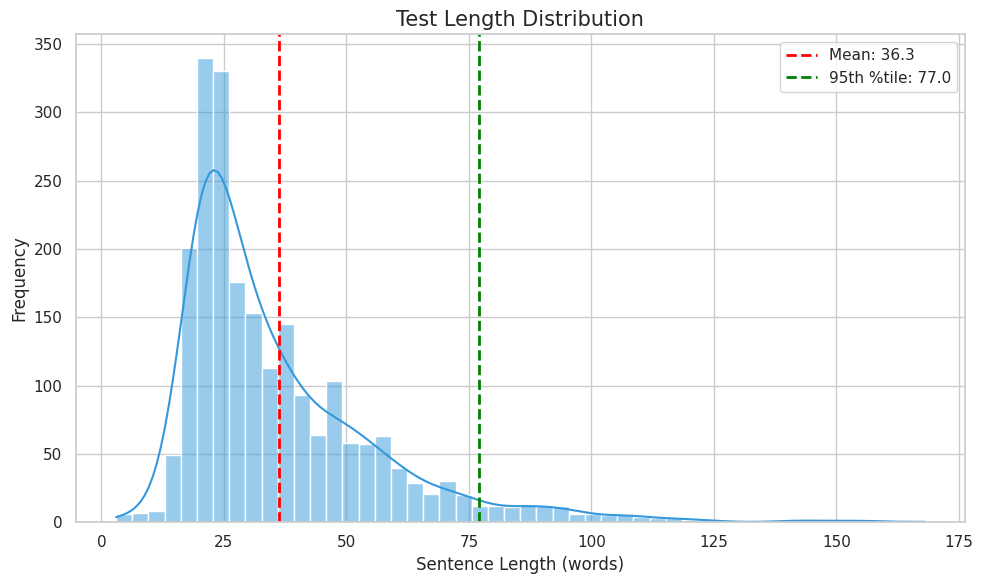

[Test Length Distribution] Statistics:
  - Mean length: 36.28
  - Max length:  168
  - Min length:  3
  - 95th %tile:  77.00


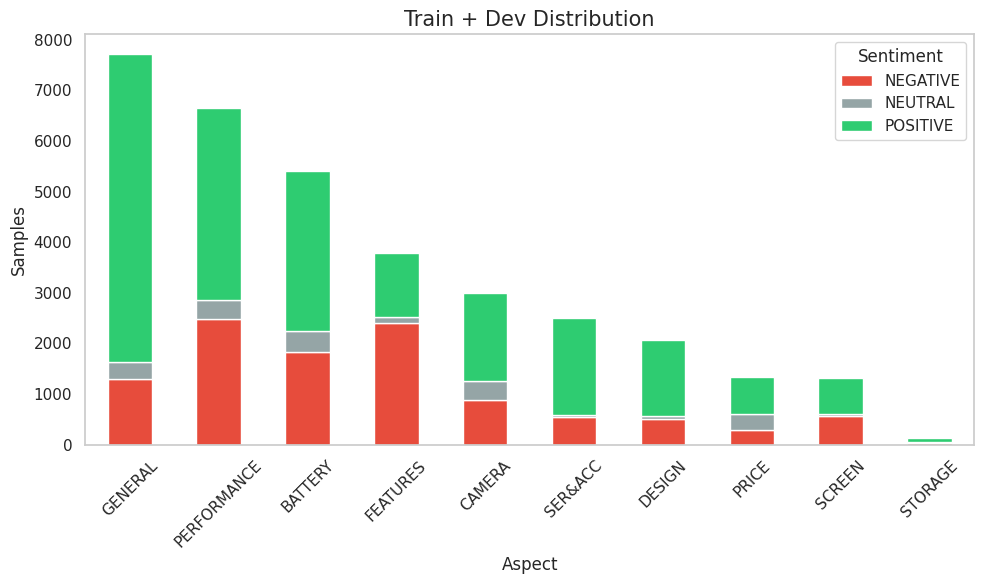

Total samples: 33918


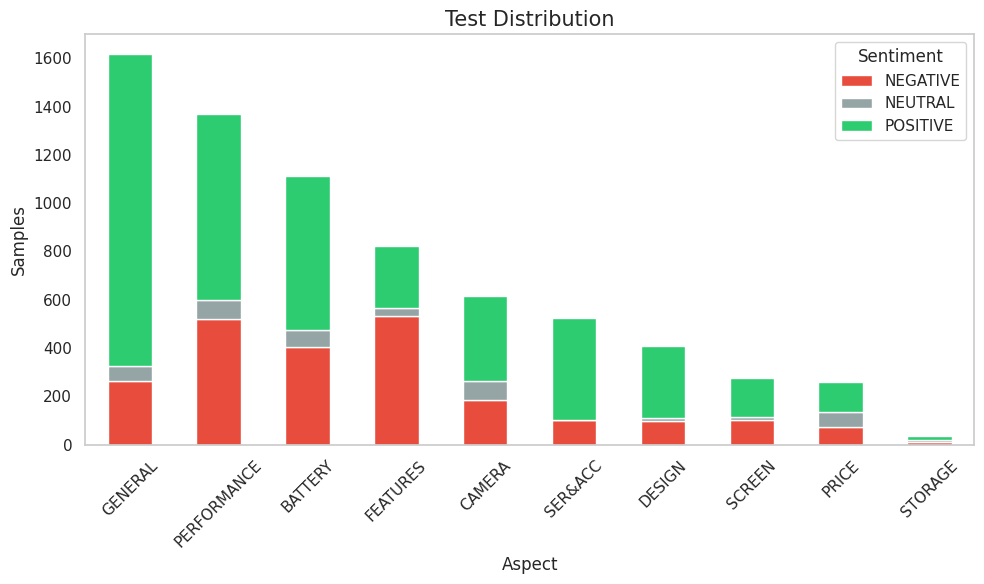

Total samples: 7043


In [19]:
seed_everything(Config.SEED)
print(f"[INFO] Running on device: {Config.DEVICE}")

# 1. Setup & Data Loading
data_path = Config.DATA_DIR
prep = Preprocessor(vncore_dir=Config.VNCORE_DIR)

print("[INFO] Loading and preprocessing data...")
train_raw = read_jsonl(os.path.join(data_path, "train.jsonl"))
dev_raw = read_jsonl(os.path.join(data_path, "dev.jsonl"))
test_raw = read_jsonl(os.path.join(data_path, "test.jsonl"))
full_train_raw = train_raw + dev_raw

plot_sentence_length_distribution(full_train_raw, title="Train + Dev Length Distribution")
plot_sentence_length_distribution(test_raw, title="Test Length Distribution")

train_df_count = plot_aspect_distribution(full_train_raw, title="Train + Dev Distribution")
test_df_count = plot_aspect_distribution(test_raw, title="Test Distribution")

In [14]:
full_train_dataset = prep.process_data(full_train_raw, "Train Processing")
test_dataset = prep.process_data(test_raw, "Test Processing")
prep.build_vocabs(full_train_dataset)

Train Processing:   0%|          | 0/10634 [00:00<?, ?it/s]

Test Processing:   0%|          | 0/2225 [00:00<?, ?it/s]

[INFO] Vocab Built | Syllables: 15851, Chars: 342



========== FOLD 1/5 ==========


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

Training:   0%|          | 0/266 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]

Ep 1 | Overral | Train Loss: 63.6868 | Val Loss: 37.2850 | Val F1: 0.3313 | Val F1 (Span): 0.3762
>>> New Global Best Model Saved!


Training:   0%|          | 0/266 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]

Ep 2 | Overral | Train Loss: 34.0811 | Val Loss: 28.5195 | Val F1: 0.4034 | Val F1 (Span): 0.4538
>>> New Global Best Model Saved!


Training:   0%|          | 0/266 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]

Ep 3 | Overral | Train Loss: 25.3924 | Val Loss: 23.2922 | Val F1: 0.4388 | Val F1 (Span): 0.4882
>>> New Global Best Model Saved!


Training:   0%|          | 0/266 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]

Ep 4 | Overral | Train Loss: 19.7180 | Val Loss: 20.8670 | Val F1: 0.4627 | Val F1 (Span): 0.5078
>>> New Global Best Model Saved!


Training:   0%|          | 0/266 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]

Ep 5 | Overral | Train Loss: 15.6028 | Val Loss: 18.7581 | Val F1: 0.4826 | Val F1 (Span): 0.5315
>>> New Global Best Model Saved!


Training:   0%|          | 0/266 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]

Ep 6 | Overral | Train Loss: 13.2401 | Val Loss: 17.1798 | Val F1: 0.4931 | Val F1 (Span): 0.5412
>>> New Global Best Model Saved!


Training:   0%|          | 0/266 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]

Ep 7 | Overral | Train Loss: 11.1506 | Val Loss: 16.2868 | Val F1: 0.4997 | Val F1 (Span): 0.5474
>>> New Global Best Model Saved!


Training:   0%|          | 0/266 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]

Ep 8 | Overral | Train Loss: 9.7075 | Val Loss: 15.3503 | Val F1: 0.5082 | Val F1 (Span): 0.5563
>>> New Global Best Model Saved!


Training:   0%|          | 0/266 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]

Ep 9 | Overral | Train Loss: 8.5054 | Val Loss: 14.9509 | Val F1: 0.5123 | Val F1 (Span): 0.5614
>>> New Global Best Model Saved!


Training:   0%|          | 0/266 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]

Ep 10 | Overral | Train Loss: 7.7588 | Val Loss: 14.4983 | Val F1: 0.5126 | Val F1 (Span): 0.5597
>>> New Global Best Model Saved!


Training:   0%|          | 0/266 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]

Ep 11 | Overral | Train Loss: 6.7892 | Val Loss: 13.8643 | Val F1: 0.5311 | Val F1 (Span): 0.5745
>>> New Global Best Model Saved!


Training:   0%|          | 0/266 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]

Ep 12 | Overral | Train Loss: 6.1040 | Val Loss: 13.8485 | Val F1: 0.5186 | Val F1 (Span): 0.5650


Training:   0%|          | 0/266 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]

Ep 13 | Overral | Train Loss: 5.7938 | Val Loss: 13.1298 | Val F1: 0.5251 | Val F1 (Span): 0.5711


Training:   0%|          | 0/266 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]

Ep 14 | Overral | Train Loss: 5.3504 | Val Loss: 12.8001 | Val F1: 0.5302 | Val F1 (Span): 0.5773


Training:   0%|          | 0/266 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]

Ep 15 | Overral | Train Loss: 4.5884 | Val Loss: 12.6738 | Val F1: 0.5358 | Val F1 (Span): 0.5822
>>> New Global Best Model Saved!


Training:   0%|          | 0/266 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]

Ep 16 | Overral | Train Loss: 4.3408 | Val Loss: 12.6163 | Val F1: 0.5406 | Val F1 (Span): 0.5843
>>> New Global Best Model Saved!


Training:   0%|          | 0/266 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]

Ep 17 | Overral | Train Loss: 4.0900 | Val Loss: 12.5447 | Val F1: 0.5366 | Val F1 (Span): 0.5797


Training:   0%|          | 0/266 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]

Ep 18 | Overral | Train Loss: 3.8859 | Val Loss: 12.8266 | Val F1: 0.5389 | Val F1 (Span): 0.5851


Training:   0%|          | 0/266 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]

Ep 19 | Overral | Train Loss: 3.5890 | Val Loss: 12.7688 | Val F1: 0.5375 | Val F1 (Span): 0.5845


Training:   0%|          | 0/266 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]

Ep 20 | Overral | Train Loss: 3.3389 | Val Loss: 12.5329 | Val F1: 0.5380 | Val F1 (Span): 0.5833


Training:   0%|          | 0/266 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/67 [00:00<?, ?it/s]

Ep 21 | Overral | Train Loss: 3.1834 | Val Loss: 12.6462 | Val F1: 0.5395 | Val F1 (Span): 0.5841
>>> Early Stopping

>>> Plotting history for Fold 1...


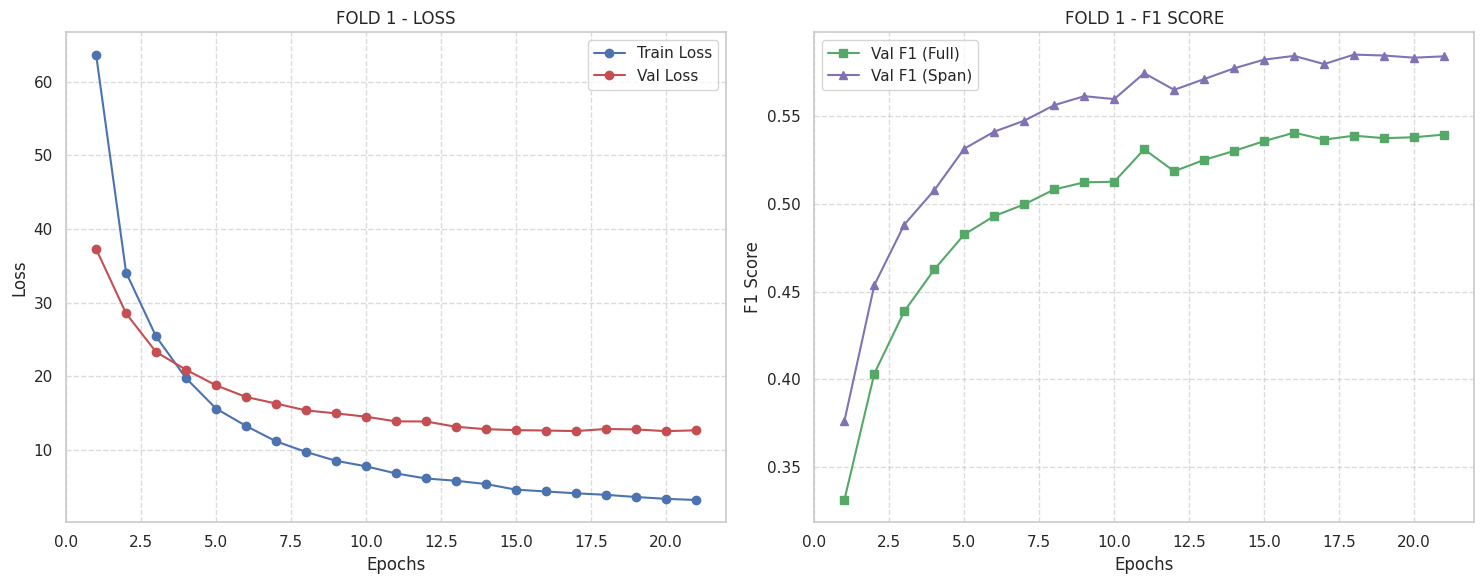

In [15]:
# 2. Cross Validation Loop
kf = KFold(n_splits=Config.KFOLD_SPLIT, shuffle=True, random_state=Config.SEED)
dataset_arr = np.array(full_train_dataset)

collate = CollateFn(prep.syl_vocab, prep.char_vocab, prep.label_map, Config.DEVICE)

best_global_f1 = 0.0

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset_arr)):
    print(f"\n{'='*10} FOLD {fold+1}/{Config.KFOLD_SPLIT} {'='*10}")
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_f1': [],
        'val_span_f1': []
    }

    # Prepare Subsets
    train_sub = dataset_arr[train_idx]
    val_sub = dataset_arr[val_idx]
    
    train_weights = get_sample_weights(train_sub)
    sampler = WeightedRandomSampler(train_weights, len(train_weights))

    train_loader = DataLoader(ABSADataset(train_sub), batch_size=Config.BATCH_SIZE, 
                              sampler=sampler, collate_fn=collate)
    val_loader = DataLoader(ABSADataset(val_sub), batch_size=Config.BATCH_SIZE, 
                            shuffle=False, collate_fn=collate)

    # Initialize Model
    model = BiLSTM_CRF(len(prep.label_map), len(prep.syl_vocab), len(prep.char_vocab))
    model.to(Config.DEVICE)

    # Optimizer
    xlm_params = list(map(id, model.xlm.parameters()))
    base_params = filter(lambda p: id(p) not in xlm_params, model.parameters())
    optimizer = torch.optim.AdamW([
        {'params': model.xlm.parameters(), 'lr': Config.ENCODER_LR},
        {'params': base_params, 'lr': Config.LR}
    ])
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=2
    )
    scaler = GradScaler()

    # Training Loop
    best_fold_f1 = 0
    patience_counter = 0

    for epoch in range(Config.EPOCHS):
        train_loss = train_epoch(model, train_loader, optimizer, scaler)
        val_span_p, val_span_r, val_span_f1, val_p, val_r, val_f1, val_loss = evaluate(model, val_loader, prep.id2label, prep)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)
        history['val_span_f1'].append(val_span_f1)
        
        scheduler.step(val_f1)
        print(f"Ep {epoch+1} | Overral | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {val_f1:.4f} | Val F1 (Span): {val_span_f1:.4f}")

        if val_f1 > best_fold_f1:
            best_fold_f1 = val_f1
            patience_counter = 0
            if val_f1 > best_global_f1:
                best_global_f1 = val_f1
                torch.save(model.state_dict(), "best_model_visd4sa.pt")
                print(">>> New Global Best Model Saved!")
        else:
            patience_counter += 1
            if patience_counter >= Config.PATIENCE:
                print(">>> Early Stopping")
                break

    print(f"\n>>> Plotting history for Fold {fold+1}...")
    plot_fold_history(history, fold + 1)
    break 

In [16]:
# 3. Final Evaluation
final_model = BiLSTM_CRF(len(prep.label_map), len(prep.syl_vocab), len(prep.char_vocab))
final_model.load_state_dict(torch.load("best_model_visd4sa.pt"))
final_model.to(Config.DEVICE)

test_loader = DataLoader(ABSADataset(test_dataset), batch_size=Config.BATCH_SIZE, 
                         shuffle=False, collate_fn=collate)

span_precision, span_recall, span_f1, precision, recall, f1, loss = evaluate(final_model, test_loader, prep.id2label, prep, verbose=True)

print(f"\n{'='*10} SPAN DETECTION TEST EVALUATION {'='*10}")
print(f"Test Precision : {span_precision*100:.2f}%")
print(f"Test Recall    : {span_recall*100:.2f}%")
print(f"Test F1-Score  : {span_f1*100:.2f}%")

print(f"\n{'='*10} OVERRAL TEST EVALUATION {'='*10}")
print(f"Test Precision : {precision*100:.2f}%")
print(f"Test Recall    : {recall*100:.2f}%")
print(f"Test F1-Score  : {f1*100:.2f}%")

Evaluating:   0%|          | 0/70 [00:00<?, ?it/s]


=============== DETAILED REPORT BY ASPECT ===============
ASPECT          PRECISION    RECALL     F1-SCORE  
--------------------------------------------------
SCREEN          58.98        54.71      56.77     
CAMERA          61.73        58.83      60.25     
FEATURES        50.06        47.63      48.82     
BATTERY         59.59        57.45      58.50     
PERFORMANCE     55.25        50.80      52.93     
STORAGE         37.50        35.29      36.36     
DESIGN          63.14        59.76      61.40     
PRICE           45.45        38.61      41.75     
GENERAL         61.32        57.23      59.21     
SER&ACC         57.99        56.11      57.03     
--------------------------------------------------
MACRO AVG       -            -          53.30     

========== SPAN DETECTION TEST EVALUATION ==========
Test Precision : 61.79%
Test Recall    : 58.04%
Test F1-Score  : 59.86%

========== OVERRAL TEST EVALUATION ==========
Test Precision : 57.71%
Test Recall    : 54.21%
Test F

In [17]:
def show_inference_samples(model, dataset, preprocessor, collate_fn, device, num_samples=5):
    """
    Runs inference on random samples using the refactored Class-based structure.
    """
    model.eval()
    
    indices = random.sample(range(len(dataset)), num_samples)
    subset = [dataset[i] for i in indices]
    
    loader = DataLoader(
        ABSADataset(subset), 
        batch_size=len(subset), 
        collate_fn=collate_fn
    )
    
    print(f"\n{'='*20} INFERENCE SAMPLES {'='*20}")
    
    with torch.no_grad():
        for batch in loader:
            input_ids, att_mask, sw_map, syl, char, tags, mask, tokens, starts, labels, texts = batch
            pred_tags_ids = model(input_ids, att_mask, sw_map, syl, char, mask=mask)
            
            for i in range(len(subset)):
                print(f"\n--- Sample {i+1} ---")
                print(f"TEXT: {texts[i]}")
                
                # 1. Decode IDs to Labels using preprocessor
                pred_tags = [preprocessor.id2label[t] for t in pred_tags_ids[i]]
                
                # 2. Convert IOB tags to Spans using preprocessor's method
                pred_spans = set(preprocessor.iob_to_spans(tokens[i], starts[i], pred_tags))
                gold_spans = set([tuple(l) for l in labels[i]])
                
                print(f"GOLD LABELS ({len(gold_spans)}):")
                if not gold_spans: 
                    print("  (None)")
                for s, e, l in gold_spans:
                    phrase = texts[i][s:e]
                    print(f"  - [{l}]: '{phrase}'")
                
                print(f"PREDICTED ({len(pred_spans)}):")
                if not pred_spans: 
                    print("  (None)")
                for s, e, l in pred_spans:
                    phrase = texts[i][s:e]
                    is_correct = (s, e, l) in gold_spans
                    status = "✅" if is_correct else "❌"
                    print(f"  {status} [{l}]: '{phrase}'")

    
final_model = BiLSTM_CRF(len(prep.label_map), len(prep.syl_vocab), len(prep.char_vocab))
final_model.load_state_dict(torch.load("best_model_visd4sa.pt"))
final_model.to(Config.DEVICE)

show_inference_samples(
    model=final_model,
    dataset=test_dataset,
    preprocessor=prep,
    collate_fn=collate,
    device=Config.DEVICE,
    num_samples=5
)


==================== INFERENCE SAMPLES ====================

--- Sample 1 ---
TEXT: Sản phẩm sài tốt game mượt, hoàn hảo chưa có vấn đề gì.nhân viên phục vụ rất tốt 👍👍😄😄
GOLD LABELS (4):
  - [PERFORMANCE#POSITIVE]: 'game mượt'
  - [SER&ACC#POSITIVE]: 'nhân viên phục vụ rất tốt'
  - [GENERAL#POSITIVE]: 'hoàn hảo chưa có vấn đề gì'
  - [GENERAL#POSITIVE]: 'Sản phẩm sài tốt'
PREDICTED (3):
  ❌ [PERFORMANCE#POSITIVE]: 'game mượt, hoàn hảo chưa có vấn đề'
  ❌ [SER&ACC#POSITIVE]: 'gì.nhân viên phục vụ rất tốt'
  ✅ [GENERAL#POSITIVE]: 'Sản phẩm sài tốt'

--- Sample 2 ---
TEXT: Sau hơn một tháng sử dụng mình đánh giá tất cả mọi thứ OK nha , không biết sao nhiều người nói nhiều lỗi nhỉ , mình chưa bị bất kỳ lỗi nào, lần đầu mình mua điện thoại của hãng Xiaomi cảm thấy rất xứng đáng khi mua em nó.
GOLD LABELS (1):
  - [GENERAL#POSITIVE]: 'mình đánh giá tất cả mọi thứ OK nha'
PREDICTED (1):
  ❌ [GENERAL#POSITIVE]: 'tất cả mọi thứ OK nha'

--- Sample 3 ---
TEXT: Máy sài rất oke. Chơi game mượt kh

Getting Predictions:   0%|          | 0/70 [00:00<?, ?it/s]

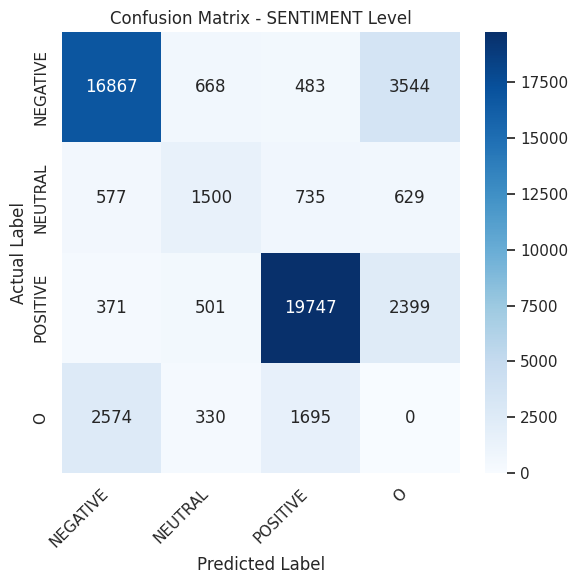

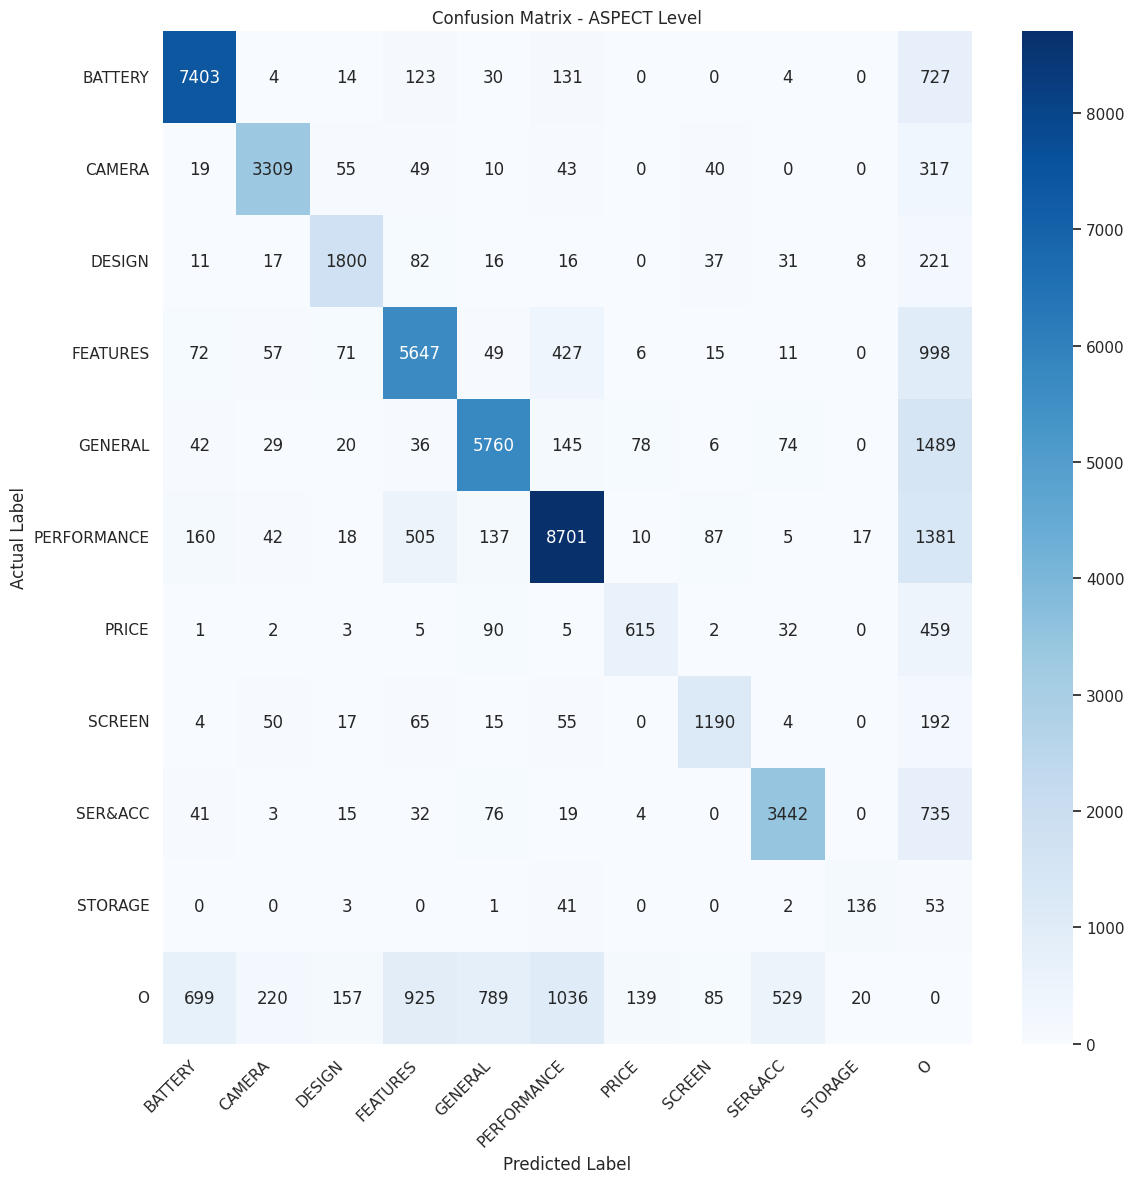

In [18]:
raw_golds, raw_preds = get_predictions_arrays(final_model, test_loader)
plot_confusion_matrix_heatmap(raw_golds, raw_preds, prep.id2label, mode='sentiment', fig_size=(6, 6))
plot_confusion_matrix_heatmap(raw_golds, raw_preds, prep.id2label, mode='aspect', fig_size=(12, 12))